In [1]:
'''
Author: Mauricio Gracia
Institute: Universidad Tecnica Federico Santa Maria
Documentation: See README.txt for detailed information
'''

# Import necessary libraries
import numpy as np           # For numerical operations
import matplotlib.pyplot as plt  # For plotting data
import pandas as pd          # For data manipulation and analysis
import glob                  # For file pattern matching and loading


## Initial Mass Funtion
We created fucntion that assings the initial stellar mass folowing the Kroupa (et.al 2000) iniatial mass funtion, with minimum mass and maximum mass as imputs. 

Each $\alpha$ used was randomly generated within the margin of error for each star before calculating the weights for thr probability distribution.

In [3]:
def kroupa_imf(min_mass, max_mass):  # In solar mass
    """
    Generates an initial stellar mass following the Kroupa Initial Mass Function (IMF) with randomly varied power-law indices.

    Parameters:
    - min_mass: float - Minimum stellar mass to consider (in solar masses).
    - max_mass: float - Maximum stellar mass to consider (in solar masses).

    Returns:
    - initial_mass: float - A randomly selected stellar mass based on the IMF.
    - alpha0, alpha1, alpha2, alpha3: float - The power-law indices used for each mass range, with random variation.
    """
    
    # Define the power-law indices for the Kroupa IMF with random variation
    alpha0 = np.random.uniform(0.3 - 0.7, 0.3 + 0.7)  # Random alpha0 in range 0.3 ± 0.7
    alpha1 = np.random.uniform(1.3 - 0.5, 1.3 + 0.5)  # Random alpha1 in range 1.3 ± 0.5
    alpha2 = np.random.uniform(2.3 - 0.3, 2.3 + 0.3)  # Random alpha2 in range 2.3 ± 0.3
    alpha3 = np.random.uniform(2.3 - 0.7, 2.3 + 0.7)  # Random alpha3 in range 2.3 ± 0.7

    # Define mass ranges based on the Kroupa IMF criteria
    m0 = (0.01, 0.08)  # Brown dwarfs and very low-mass stars
    m1 = (0.08, 0.5)   # Low-mass stars
    m2 = (0.5, 1)      # Solar-type stars
    m3 = (1, max_mass) # Higher mass stars up to the maximum specified mass

    # Generate an array of possible masses within the given range
    masses = np.arange(min_mass, max_mass, step=0.01)

    # Calculate weights for the probability distribution based on each mass range and its power-law
    # The weight for each mass is proportional to m^(1 - alpha) within each respective range
    w0 = [m**(1 - alpha0) for m in masses if m0[0] <= m < m0[1]]
    w1 = [m**(1 - alpha1) for m in masses if m1[0] <= m < m1[1]]
    w2 = [m**(1 - alpha2) for m in masses if m2[0] <= m < m2[1]]
    w3 = [m**(1 - alpha3) for m in masses if m3[0] <= m < m3[1]]

    # Combine weights from all ranges into a single array
    weights = np.concatenate([w0, w1, w2, w3])

    # Normalize weights to create a probability distribution (sums to 1)
    probabilities = weights / np.sum(weights)

    # Sample a random initial stellar mass from the probability distribution
    initial_mass = np.random.choice(masses, size=1, p=probabilities)
    
    # Return the sampled mass along with the randomly selected power-law indices (alphas)
    return initial_mass, alpha0, alpha1, alpha2, alpha3


In [376]:
def assign_star_age(max_age):
    """
    Assigns a random age to a star, assuming a uniform distribution over the galaxy's age.

    Parameters:
    - max_age: float - Maximum possible age (in Gyr), representing the age of the Milky Way or the star formation period.

    Returns:
    - float - A randomly assigned birth time (in Gyr) between 0 and max_age.
    """

    # The Milky Way is approximately 10 Gyr old.
    # Assuming a constant star formation rate, we use a uniform distribution for birth times.
    # This generates a random birth time between 0 and max_age, reflecting the star formation timeframe.
    
    return np.random.uniform(0, max_age)


6.581694488879558


In [7]:
def main_sequence_lifetime(mass, birth_time, max_age):
    """
    Determines the main sequence lifetime of a star and whether it has ended its main sequence phase.

    Parameters:
    - mass: float - Stellar mass in solar masses (Msun).
    - birth_time: float - The birth time of the star in Gyr.
    - max_age: float - Maximum possible age of the galaxy (in Gyr).

    Returns:
    - tuple:
        - t_ms: float - Estimated main sequence lifetime of the star in Gyr.
        - bool - True if the star has ended its main sequence life, False otherwise.
    """
    
    # Estimate main sequence lifetime using the mass-luminosity relation for stars up to ~55 Msun
    # The formula assumes lifetime ~ 1 / mass^2.5, based on the relation: luminosity ~ mass^3.5.
    # For a 1 Msun star, the main sequence lifetime is normalized to about 10 Gyr.
    t_ms = 10 / (mass**2.5)  # Main sequence lifetime in Gyr

    # Determine if the star has ended its main sequence phase
    # Calculate the difference between the main sequence lifetime and birth time.
    # If t_ms - birth_time > 0, then the star has already exhausted its main sequence lifetime.
    if t_ms - birth_time > 0:
        return t_ms, True  # Star has ended its main sequence phase
    else:
        return t_ms, False  # Star is still in its main sequence phase


In [9]:
def determine_stellar_remnant(initial_mass):
    """
    Determines the stellar remnant type (White Dwarf, Neutron Star, or Black Hole) based on the initial mass.
    Uses different Initial-Final Mass Relations (IFMRs) for each remnant type to calculate the final remnant mass.

    Parameters:
    - initial_mass: float - The initial mass of the star (in solar masses).

    Returns:
    - tuple:
        - final_mass: float or None - The final mass of the remnant, or None if the remnant type is unknown.
        - remnant_type: str - Type of the remnant ('White_Dwarf', 'Neutron_Star', 'Black_Hole', or 'Unknown').
    """

    # Define IFMR for White Dwarf based on initial mass
    def white_dwarf_ifmr(initial_mass):
        # White Dwarfs are observed up to ~6.5 Msun (Ferrario et al., 2005)
        if initial_mass <= 6.5:
            # White Dwarf IFMR from Kalirai et al. (2008) with random variation
            c1 = np.random.uniform(0.109 - 0.007, 0.109 + 0.007)  # Coefficient with random variation
            c2 = np.random.uniform(0.394 - 0.025, 0.394 + 0.025)  # Intercept with random variation
            
            return c1 * initial_mass + c2  # Final mass for White Dwarf
        else:
            return False  # Indicates the star is not a White Dwarf candidate

    # Define IFMR for Neutron Star based on initial mass
    def neutron_star_ifmr(initial_mass):
        # Branch I, II, III, and IV relations from Raithel et al. (2018)
        if 9 <= initial_mass <= 13:
            return 2.24 + 0.508 * (initial_mass - 14.75) + 0.125 * (initial_mass - 14.75)**2 + 0.0110 * (initial_mass - 14.75)**3
        elif 9 < initial_mass < 13:
            return 0.123 + 0.112 * initial_mass
        elif 15 <= initial_mass <= 17.8:
            return 0.996 + 0.0384 * initial_mass
        elif 17.8 < initial_mass < 18.5:
            return -0.020 + 0.1 * initial_mass
        else:
            return False  # Indicates the star is not a Neutron Star candidate

    # Define IFMR for Black Hole based on initial mass and ejection fraction
    def black_hole_ifmr(initial_mass, fej=0.9):
        # Branch II: Implosion of CO-core (45 Msun ≤ initial_mass ≤ 120 Msun)
        if 45 <= initial_mass <= 120:
            mbh_core = 5.697 + 7.8598 * (10**8) * initial_mass**(-4.858)  # Core mass for high mass stars
            mbh_all = 0  # Assuming no remnant if entire star ejects
            
            # Calculate final mass based on ejection fraction
            mbh = fej * mbh_core + (1 - fej) * mbh_all
            return mbh

        # Branch I: Implosion of He-core or entire star (15 Msun ≤ initial_mass ≤ 40 Msun)
        elif 15 <= initial_mass <= 40:
            mbh_core = -2.049 + 0.414 * initial_mass  # Final mass assuming only the core remains
            mbh_all = 15.52 - 0.3294 * (initial_mass - 25.97) - 0.02121 * (initial_mass - 25.97)**2 + 0.003120 * (initial_mass - 25.97)**3
            
            # Interpolate between core-only and full-star remnant based on ejection fraction
            mbh = fej * mbh_core + (1 - fej) * mbh_all
            return mbh

        else:
            return False  # Indicates the star is not a Black Hole candidate

    # Apply White Dwarf IFMR to determine final mass if it fits the criteria
    final_mass_whithe_dwarf = white_dwarf_ifmr(initial_mass)
    
    # Apply Neutron Star IFMR if White Dwarf criteria are not met
    final_mass_neutron_star = neutron_star_ifmr(initial_mass)
    
    # Apply Black Hole IFMR if neither White Dwarf nor Neutron Star criteria are met
    final_mass_black_hole = black_hole_ifmr(initial_mass)
    
    # Determine the remnant type based on final masses
    if final_mass_whithe_dwarf:
        final_mass = final_mass_whithe_dwarf
        remnant_type = 'White_Dwarf'
    
    elif final_mass_neutron_star:
        final_mass = final_mass_neutron_star
        remnant_type = 'Neutron_Star' 
    
    elif final_mass_black_hole:
        final_mass = final_mass_black_hole
        remnant_type = 'Black_Hole' 
        
    # If no criteria are met, set remnant type to 'Unknown'
    else:
        final_mass = None
        remnant_type = 'Unknown'
    
    return final_mass, remnant_type


In [11]:
def make_star_life(min_mass, max_mass, max_age):
    """
    Simulates the life of a single star, generating its initial properties, 
    main sequence lifetime, and eventual remnant type based on its mass.

    Parameters:
    - min_mass: float - Minimum initial mass for the star (in solar masses).
    - max_mass: float - Maximum initial mass for the star (in solar masses).
    - max_age: float - Maximum possible age of the galaxy (in Gyr).

    Returns:
    - dict: A dictionary containing the star's initial and final properties, 
            including its initial mass, birth time, main sequence status, 
            final mass, and remnant type.
    """

    # Generate stellar mass based on the Kroupa IMF
    # The Kroupa IMF returns the initial mass and the power-law indices (alpha0-3)
    stellar_mass, alpha0, alpha1, alpha2, alpha3 = kroupa_imf(min_mass, max_mass)
    
    # Assign a birth time (age) uniformly distributed between 0 and max_age
    age = assign_star_age(max_age)

    # Calculate main sequence lifetime (msl) and status (mss) based on the stellar mass and age
    # msl (main sequence life) is the estimated time the star spends on the main sequence
    # mss (main sequence status) is True if the star has ended its main sequence phase
    msl, mss = main_sequence_lifetime(stellar_mass, age, max_age)
    
    # Determine if the star is a stellar remnant based on its main sequence status
    if not mss:  # If mss is False, the star has finished the main sequence
        final_stellar_mass, remenant_type = determine_stellar_remnant(stellar_mass)
    else:  # Star is still on the main sequence
        final_stellar_mass, remenant_type = stellar_mass, 'In_Main_Sequence'
    
    # Collect star properties in a dictionary
    star_dic = {
        'initail_mass': stellar_mass[0],  # Initial stellar mass
        'alpha0': alpha0,                 # IMF power-law index for low mass range
        'alpha1': alpha1,                 # IMF power-law index for intermediate-low mass range
        'alpha2': alpha2,                 # IMF power-law index for intermediate-high mass range
        'alpha3': alpha3,                 # IMF power-law index for high mass range
        't_born': age,                    # Birth time (age) of the star in Gyr
        't_ms': msl[0],                   # Main sequence lifetime in Gyr
        'ms_status': mss,                 # Main sequence status (True if ended)
        'final_mass': final_stellar_mass[0] if final_stellar_mass is not None else None,  # Final mass if remnant, else None
        'remenant_type': remenant_type    # Type of remnant or 'In_Main_Sequence'
    }

    return star_dic


In [5]:
##############################################################
###################### INPUT VARIABLES #######################
##############################################################

# Array specifying the number of stars to simulate for each scenario
numbers_of_stars = np.array([100, 1000, 10000, 100000, 1000000])

# Minimum stellar mass to consider (in solar masses, Msun)
min_mass = 0.08  # Typically the minimum mass for hydrogen fusion in stars

# Maximum stellar mass to consider (in solar masses, Msun)
max_mass = 100  # Typical upper mass limit for stars in astrophysical studies

# Maximum age for stars (in Gyr), roughly the age of the Milky Way
max_star_age = 10  # Assumes stars have formed throughout the Milky Way's 10 Gyr history

##############################################################
##############################################################
##############################################################


In [ ]:
## Create dictionary to store all simulation data and save it to data frames
import time

# Start timing the entire simulation process
start_time = time.time()

# Loop over each number of stars specified for simulation
for i in numbers_of_stars:  # For all simulations
    stars_specific = []  # Initialize a list to store each star's data in this simulation

    # Generate individual star data for the specified number of stars (i)
    for j in range(i):
        stars_specific.append(make_star_life(min_mass, max_mass, max_star_age))  # Append each star's data

    # Convert the list of star dictionaries to a DataFrame
    df = pd.DataFrame(stars_specific)

    # Save the DataFrame as a CSV file, naming it based on the number of stars in this simulation
    df.to_csv(f'simulation_{i}_stars.csv', index=True) 

    # Calculate and print the time elapsed for the current simulation
    end_time = time.time()
    d_time = end_time - start_time
    print(f'Done for {i} stars (time elapsed = {d_time:.2f}s)')


In [7]:
## Load data frames

# Initialize a dictionary to store the loaded DataFrames, using the number of stars as keys
dataframes = {}

# Use glob to find all CSV files that match the pattern 'simulation_*_stars.csv'
csv_files = glob.glob('simulation_*_stars.csv')

# Loop over each CSV file found in the directory
for file in csv_files:
    # Extract the number of stars from the filename, assuming format: "simulation_X_stars.csv"
    num_stars = file.split('_')[1]  # Extract the number of stars (X) as a string
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Store the DataFrame in the dictionary with `num_stars` as the key
    dataframes[num_stars] = df


In [9]:
# Access each DataFrame from the dictionary by the number of stars
# Using numbers_of_stars array to dynamically create variables
dataframes_by_star_count = {f"df_{num}_stars": dataframes.get(str(num)) for num in numbers_of_stars}


In [11]:
def get_norm_hist(Data_Frame, category, bins=100, density=False, log=True):
    """
    Generates normalized histograms for various stellar remnant types within a DataFrame based on a specified category.
    
    Parameters:
    - Data_Frame: pd.DataFrame - The data containing stellar remnant information.
    - category: str - The column name in the DataFrame to be analyzed.
    - bins: int - Number of bins to use for the histograms (default is 100).
    - density: bool - If True, the histogram is normalized to form a probability density (default is False).
    - log: bool - If True, log-transforms the category values before computing histograms (default is True).

    Returns:
    - list: Contains two elements:
        - counts_cube: 2D array of normalized histogram counts for each remnant type.
        - bins_cube: 2D array of bin edges for each remnant type.
    """

    # Filter the DataFrame by remnant type to create separate subsets for each type of stellar remnant
    main_sequence = Data_Frame[Data_Frame['remenant_type'] == 'In_Main_Sequence']
    white_dwarfs  = Data_Frame[Data_Frame['remenant_type'] == 'White_Dwarf']
    neutron_stars = Data_Frame[Data_Frame['remenant_type'] == 'Neutron_Star']
    black_holes   = Data_Frame[Data_Frame['remenant_type'] == 'Black_Hole']

    # Total number of stars in the dataset, used to normalize histogram counts
    stars_total = Data_Frame.shape[0]

    # Check if logarithmic transformation is requested
    if log:
        # Log-transform the values in the category column for the entire dataset to define consistent bin limits
        log_data = np.log10(Data_Frame[category])
        limits = (np.min(log_data), np.max(log_data))  # Define the min-max range for all histograms to use

        # Calculate histograms for each remnant type on a log scale, using the same bin limits for all
        main_sequence_counts, main_sequence_bins = np.histogram(np.log10(main_sequence[category]), bins=bins, density=density, range=limits)
        white_dwarfs_counts, white_dwarfs_bins = np.histogram(np.log10(white_dwarfs[category]), bins=bins, density=density, range=limits)
        neutron_stars_counts, neutron_stars_bins = np.histogram(np.log10(neutron_stars[category]), bins=bins, density=density, range=limits)
        black_holes_counts, black_holes_bins = np.histogram(np.log10(black_holes[category]), bins=bins, density=density, range=limits)
        
    else:
        # For non-log scale, use the raw values of the category column to define consistent bin limits
        log_data = Data_Frame[category]
        limits = (np.min(log_data), np.max(log_data))

        # Calculate histograms for each remnant type on a linear scale, using the same bin limits for all
        main_sequence_counts, main_sequence_bins = np.histogram(main_sequence[category], bins=bins, density=density, range=limits)
        white_dwarfs_counts, white_dwarfs_bins = np.histogram(white_dwarfs[category], bins=bins, density=density, range=limits)
        neutron_stars_counts, neutron_stars_bins = np.histogram(neutron_stars[category], bins=bins, density=density, range=limits)
        black_holes_counts, black_holes_bins = np.histogram(black_holes[category], bins=bins, density=density, range=limits)

    # Normalize histogram counts by dividing by the total number of stars
    
    main_sequence_counts = main_sequence_counts/stars_total
    white_dwarfs_counts  = white_dwarfs_counts/stars_total
    neutron_stars_counts = neutron_stars_counts/stars_total
    black_holes_counts   = black_holes_counts/stars_total

    # Stack the normalized counts and bin edges for all remnant types into arrays
    counts_cube = np.stack([main_sequence_counts, white_dwarfs_counts, neutron_stars_counts, black_holes_counts])
    bins_cube = np.stack([main_sequence_bins, white_dwarfs_bins, neutron_stars_bins, black_holes_bins])

    # Calculate the center of each bin to facilitate plotting
    bins_center_cube = (bins_cube[:, :-1] + bins_cube[:, 1:]) / 2

    # Replace bins with zero counts in `counts_cube` with NaN in `bins_center_cube` to avoid plotting empty bins
    bins_center_cube = np.where(counts_cube == 0, np.nan, bins_center_cube)

    # Return the final arrays: `counts_cube` for normalized counts and `bins_cube` for bin edges
    return [counts_cube, bins_cube]


In [8]:
## Get the normalized histogram for the final mass of each star

# Define the category to analyze
category = 'final_mass'

# Dictionary to store the histogram results for each star count
mass_histograms = {}

# Loop through each DataFrame in dataframes_by_star_count
for star_count, df in dataframes_by_star_count.items():
    # Calculate the normalized histogram for the specified category and store it in the dictionary
    mass_histograms[star_count] = get_norm_hist(df, category)


In [23]:
## Get the normalized histogram for the age of each star

# Define the category to analyze
category = 't_born'

# Dictionary to store the age histogram results for each star count
age_histograms = {}

# Loop through each DataFrame in dataframes_by_star_count
for star_count, df in dataframes_by_star_count.items():
    # Calculate the normalized histogram for the age category, without log transformation
    age_hist = get_norm_hist(df, category, log=False)
    
    # Store the adjusted histogram in the dictionary
    age_histograms[star_count] = age_hist


<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
/var/folders/3p/2l6yb6tn6l9gpjx8yvg0xcsc0000gn/T/ipykernel_3138/2450122244.py:37: SyntaxWarning: invalid escape sequence '\l'
  axes[-1].set_xlabel('Mass [$\log_{10}(M_\odot)$]')
/var/folders/3p/2l6yb6tn6l9gpjx8yvg0xcsc0000gn/T/ipykernel_3138/2450122244.py:37: SyntaxWarning: invalid escape sequence '\l'
  axes[-1].set_xlabel('Mass [$\log_{10}(M_\odot)$]')


NameError: name 'mass_histograms' is not defined

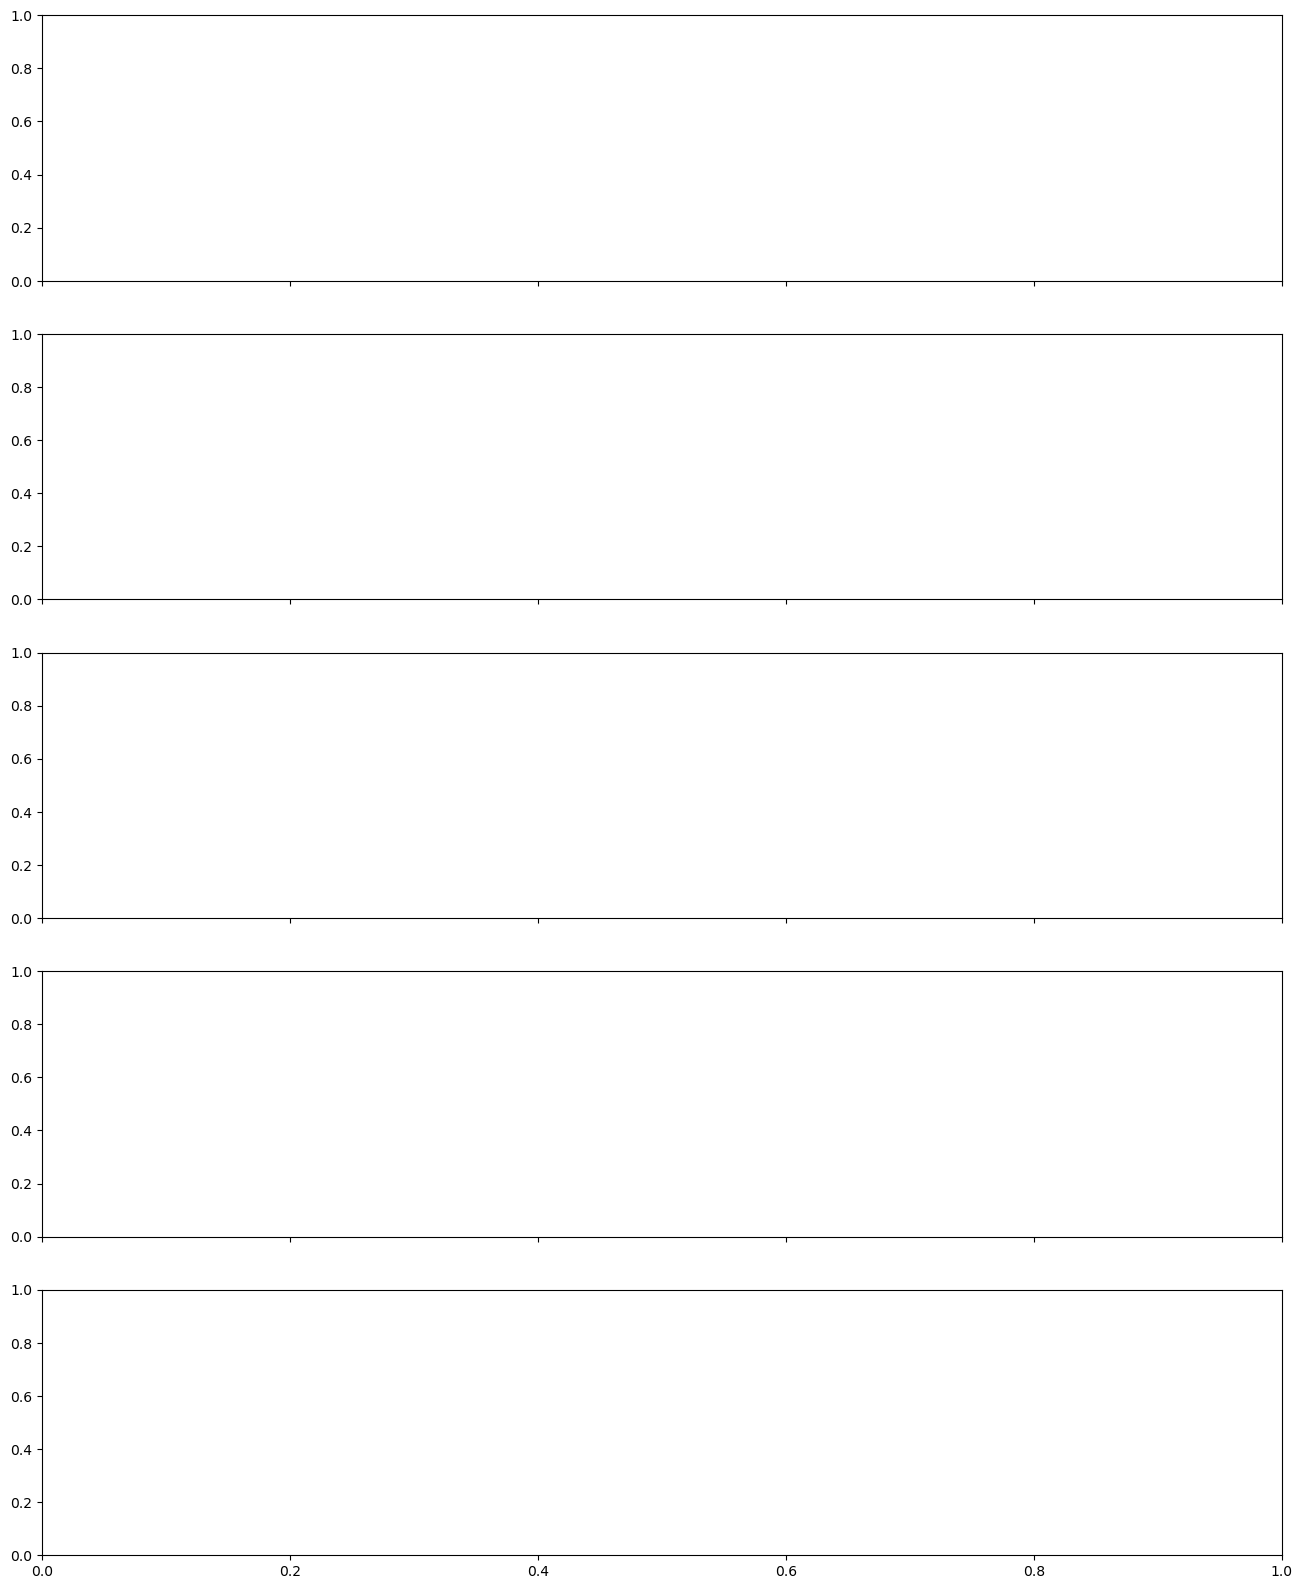

In [19]:
# Plot for mass histograms across different star counts
n = len(numbers_of_stars)
fig, axes = plt.subplots(n, 1, sharex=True, figsize=(16, 4 * n))

# Loop through each star simulation count to plot on each subplot
for i, num_stars in enumerate(numbers_of_stars):
    # Retrieve the precomputed histogram data for the current number of stars
    var = mass_histograms[f'df_{num_stars}_stars']
    ax = axes[i]  # Get the current subplot axis

    # Plot histograms for each stellar remnant category
    ax.step(var[1][0][:-1], var[0][0], color='black', alpha=1, label='Main Sequence')
    ax.step(var[1][1][:-1], var[0][1], color='green', alpha=1, label='White Dwarf')
    ax.step(var[1][2][:-1], var[0][2], color='orange', alpha=1, label='Neutron Star')
    ax.step(var[1][3][:-1], var[0][3], color='red', alpha=1, label='Black Hole')

    # Set y-axis label and scale
    ax.set_ylabel('Normalized count')
    ax.set_ylim(0.001, None)
    ax.grid()

    # Display the number of stars in the top-right corner
    ax.text(0.95, 0.95, f'{num_stars} stars', transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # Display legend only on the topmost plot
    if i == 0:
        ax.legend(loc="upper left")
    
    # Set x-axis properties only on the last plot
    if i == n - 1:
        ax.set_xlim(-1.2, 1.2)
        ax.set_xticks(np.arange(-1.2, 1.3, 0.2))

# Set x-axis label only on the bottom plot
axes[-1].set_xlabel('Mass [$\log_{10}(M_\odot)$]')

# Adjust spacing to align subplots tightly together
plt.subplots_adjust(hspace=0)

# Save the figure at high resolution
plt.savefig('mass_histogram_all.png', dpi=500)

# Display the plot
plt.show()


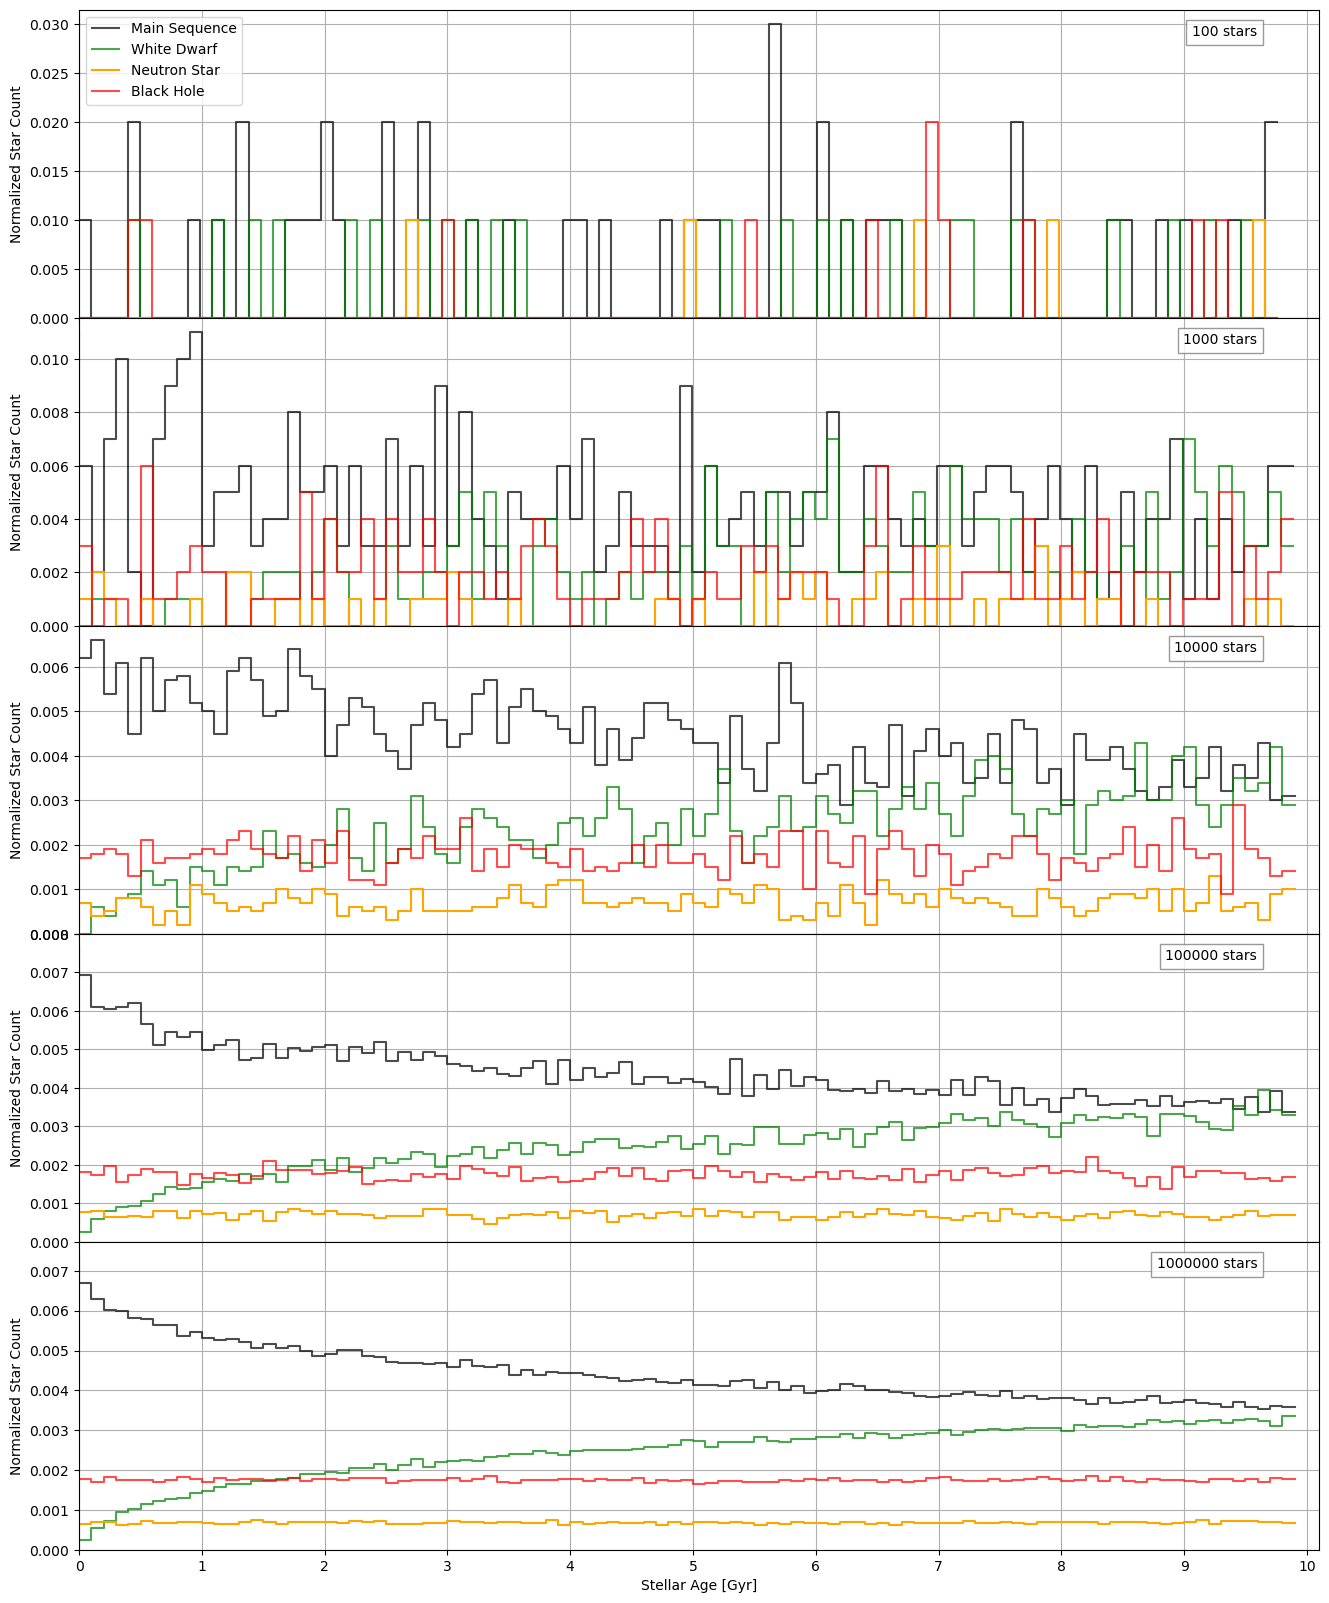

In [25]:
## Plot Histograms for Age

n = len(numbers_of_stars)
fig, axes = plt.subplots(n, 1, sharex=True, figsize=(16, 4 * n))

# Loop through each star simulation count to plot on each subplot
for i, num_stars in enumerate(numbers_of_stars):
    # Retrieve the precomputed age histogram data for the current number of stars
    var = age_histograms[f'df_{num_stars}_stars']
    ax = axes[i]  # Get the current subplot axis

    # Plot histograms for each stellar remnant category
    ax.step(var[1][0][:-1], var[0][0], color='black', alpha=0.7, label='Main Sequence')
    ax.step(var[1][1][:-1], var[0][1], color='green', alpha=0.7, label='White Dwarf')
    ax.step(var[1][2][:-1], var[0][2], color='orange', alpha=1, label='Neutron Star')
    ax.step(var[1][3][:-1], var[0][3], color='red', alpha=0.7, label='Black Hole')

    # Set y-axis label and limit
    ax.set_ylabel('Normalized Star Count')
    ax.set_ylim(0.0, None)
    ax.grid()

    # Display the number of stars in the top-right corner
    ax.text(0.95, 0.95, f'{num_stars} stars', transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # Display legend only on the topmost plot
    if i == 0:
        ax.legend(loc="upper left")
    
    # Set x-axis properties only on the last plot
    if i == n - 1:
        ax.set_xlim(0, 10.1)
        ax.set_xticks(np.arange(0, 11, 1))

# Set x-axis label only on the bottom plot
axes[-1].set_xlabel('Stellar Age [Gyr]')

# Adjust spacing to align subplots tightly together
plt.subplots_adjust(hspace=0)

# Save the figure at high resolution
plt.savefig('age_histogram_all.png', dpi=500)

# Display the plot
plt.show()


In [21]:
## Plot Histograms for Age Fractions by Remnant Type

# List of remnant types
remnant_types = ['Main Sequence', 'White Dwarf', 'Neutron Star', 'Black Hole']

# Print a separator for readability
print('-----------------------------------')

# Loop over each specified number of stars to calculate and display fractions
for i in numbers_of_stars:
    # Retrieve the age histogram data for the current star count
    var = age_histograms[f'df_{num_stars}_stars']
    
    # Calculate the fraction of each remnant type by summing the normalized counts
    fraction = [np.sum(var[0][0]), np.sum(var[0][1]), np.sum(var[0][2]), np.sum(var[0][3])]
    
    # Display the total number of stars simulated
    print(f'Stars simulated = {i}')
    
    # Print the fraction for each remnant type
    for j in range(4):
        print(f'{remnant_types[j]} fraction = {fraction[j]:.4f}')
    
    # Print a separator after each star count for readability
    print('-----------------------------------')


-----------------------------------
Stars simulated = 100
Main Sequence fraction = 0.4437
White Dwarf fraction = 0.2432
Neutron Star fraction = 0.0678
Black Hole fraction = 0.1750
-----------------------------------
Stars simulated = 1000
Main Sequence fraction = 0.4437
White Dwarf fraction = 0.2432
Neutron Star fraction = 0.0678
Black Hole fraction = 0.1750
-----------------------------------
Stars simulated = 10000
Main Sequence fraction = 0.4437
White Dwarf fraction = 0.2432
Neutron Star fraction = 0.0678
Black Hole fraction = 0.1750
-----------------------------------
Stars simulated = 100000
Main Sequence fraction = 0.4437
White Dwarf fraction = 0.2432
Neutron Star fraction = 0.0678
Black Hole fraction = 0.1750
-----------------------------------
Stars simulated = 1000000
Main Sequence fraction = 0.4437
White Dwarf fraction = 0.2432
Neutron Star fraction = 0.0678
Black Hole fraction = 0.1750
-----------------------------------


<>:29: SyntaxWarning: invalid escape sequence '\o'
<>:44: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\o'
<>:44: SyntaxWarning: invalid escape sequence '\o'
/var/folders/3p/2l6yb6tn6l9gpjx8yvg0xcsc0000gn/T/ipykernel_1805/98090058.py:29: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('$M_{final}$ [$M_{\odot}$]')
/var/folders/3p/2l6yb6tn6l9gpjx8yvg0xcsc0000gn/T/ipykernel_1805/98090058.py:44: SyntaxWarning: invalid escape sequence '\o'
  axes[-1].set_xlabel('$M_{initial}$ [$M_{\odot}$]')


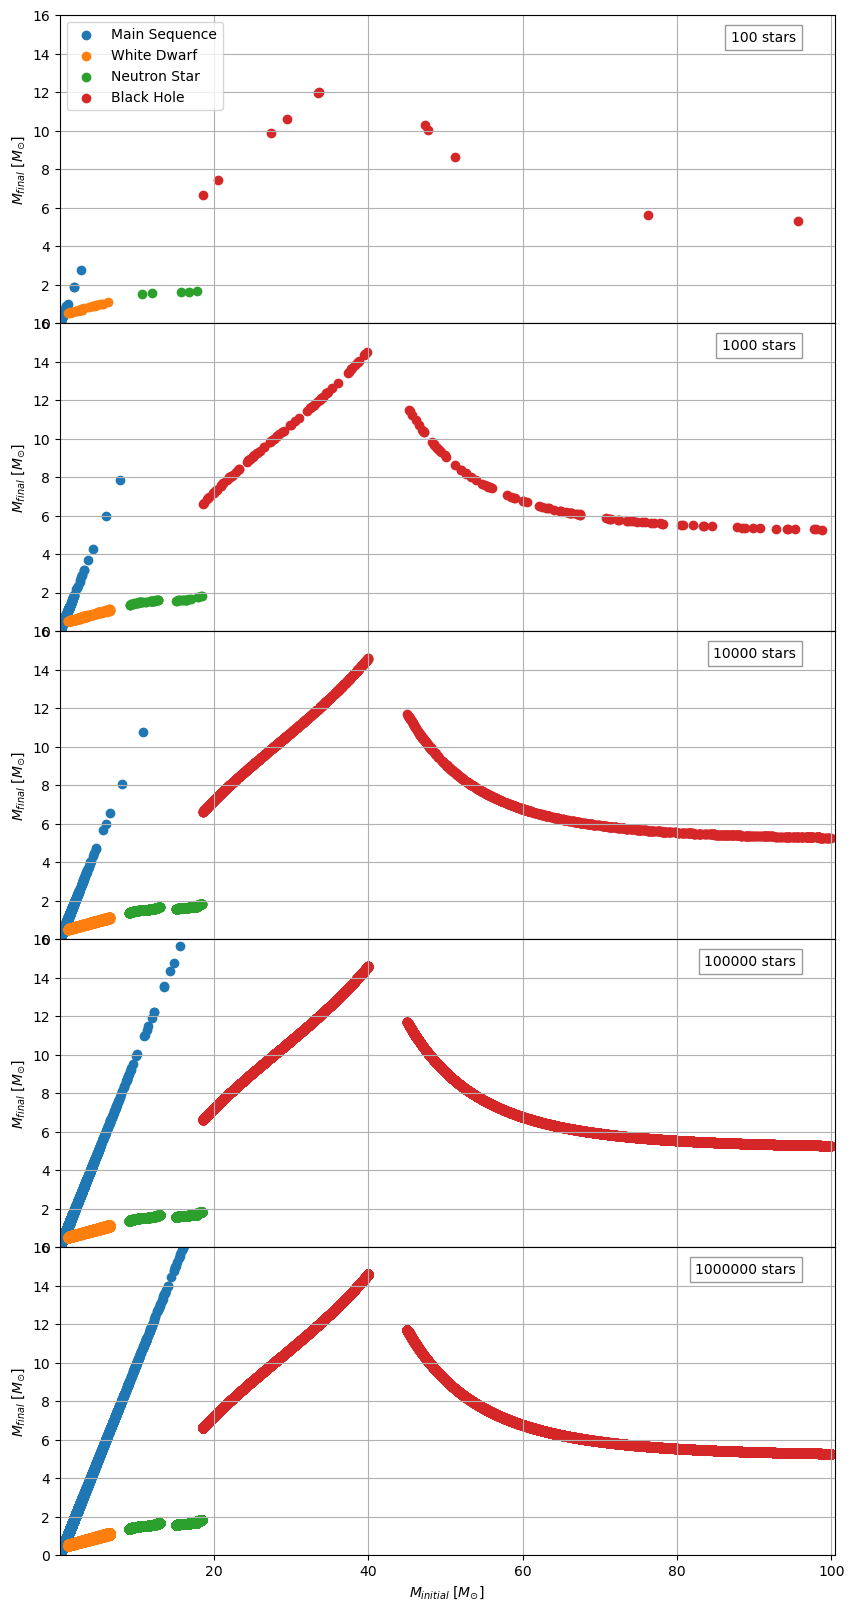

In [18]:
# Set up subplots for each star count, arranged in a vertical stack
n = len(numbers_of_stars)
fig, axes = plt.subplots(n, 1, sharex=True, figsize=(10, 4 * n))

# Loop through each specified number of stars to generate scatter plots on each subplot
for i, num_stars in enumerate(numbers_of_stars):
    # Retrieve the DataFrame for the current number of stars from dataframes_by_star_count
    var = dataframes_by_star_count[f'df_{num_stars}_stars']
    
    # Filter out rows with NaN in the 'final_mass' column
    Data_Frame = var[~np.isnan(var['final_mass'])]

    # Separate the DataFrame by remnant type for individual scatter plots
    main_sequence = Data_Frame[Data_Frame['remenant_type'] == 'In_Main_Sequence']
    white_dwarfs  = Data_Frame[Data_Frame['remenant_type'] == 'White_Dwarf']
    neutron_stars = Data_Frame[Data_Frame['remenant_type'] == 'Neutron_Star']
    black_holes   = Data_Frame[Data_Frame['remenant_type'] == 'Black_Hole']

    # Select the current subplot
    ax = axes[i]

    # Scatter plots for each stellar remnant type on the current subplot
    ax.scatter(main_sequence['initail_mass'], main_sequence['final_mass'], label='Main Sequence')
    ax.scatter(white_dwarfs['initail_mass'], white_dwarfs['final_mass'], label='White Dwarf')
    ax.scatter(neutron_stars['initail_mass'], neutron_stars['final_mass'], label='Neutron Star')
    ax.scatter(black_holes['initail_mass'], black_holes['final_mass'], label='Black Hole')

    # Set y-axis label and limits for consistent scaling
    ax.set_ylabel('$M_{final}$ [$M_{\odot}$]')
    ax.set_ylim(0, 16)
    ax.set_xlim(0.001, None)
    ax.grid()

    # Display the number of stars in the top-right corner
    ax.text(0.95, 0.95, f'{num_stars} stars', transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # Only display legend on the topmost plot
    if i == 0:
        ax.legend(loc="upper left")

# Set x-axis label only on the bottom plot
axes[-1].set_xlabel('$M_{initial}$ [$M_{\odot}$]')

# Adjust spacing to align subplots closely
plt.subplots_adjust(hspace=0)

# Save the figure at high resolution
plt.savefig('initial_final_mass_scatter_all.png', dpi=500)

# Display the plots
plt.show()
